# Fit quality visualization notebook

In [1]:
# Make sure some required libraries are installed
!pip install --user -q arviz tqdm papermill

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import pystan
import re

### Parameters changed by Papermill

In [10]:
model_name = 'reducedlinearmodelNegBinom'
roi = 'US_NY'
data_path = "../data"
fits_path = "/share/fits"

### Load the data

In [11]:
data_path_ = Path(data_path) / ("covid_timeseries_%s.csv" % roi)
data = pd.read_csv(data_path_)

### Load the fits

In [12]:
fit_path = Path(fits_path) / ("%s_%s.csv" % (model_name, roi))
samples = pd.read_csv(fit_path)

#fit_path = Path(fits_path) / ("%s_%s.pkl" % (model_name, roi))
#try:
#    with open(fit_path, "rb") as f:
#        fit = pickle.load(f)
#except ModuleNotFoundError as e:
#    matches = re.findall("No module named '([a-z0-9_]+)'", str(e))
#    if matches:
#        module_name = matches[0]
#        from unpickling_tools import unpickle_fit, create_fake_model
#        fit = unpickle_fit(str(fit_path), module_name=module_name)

### Choose the parameter list

In [13]:
hist_params = ['R0:log=True']#['theta[%d]' % i for i in range(1, 9)]
time_params = ['car', 'ifr']

### Visualize samples (one histogram and color per chain)

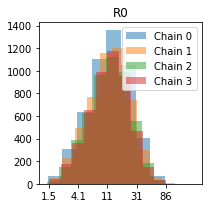

In [14]:
cols = min(len(hist_params),4)
rows = math.ceil(len(hist_params)/4)
fig, axes = plt.subplots(rows, cols, squeeze=False, figsize=(3*cols, 3*rows))
chains = samples['chain'].unique()
for i, param in enumerate(hist_params):
    options = {}
    ax = axes.flat[i]
    for chain in chains:
        if ':' in param:
            param, options = param.split(':')
            options = eval("dict(%s)" % options)
        chain_samples = samples[samples['chain']==chain][param]
        if options.get('log', False):
            chain_samples = np.log(chain_samples)
        ax.hist(chain_samples, alpha=0.5, label='Chain %d' % chain)
        if options.get('log', False):
            ax.set_xticks(np.linspace(chain_samples.min(), chain_samples.max(), 5))
            ax.set_xticklabels(['%.2g' % np.exp(x) for x in ax.get_xticks()])
        ax.set_title(param)
    plt.legend()
plt.tight_layout()

### Visualize samples across time

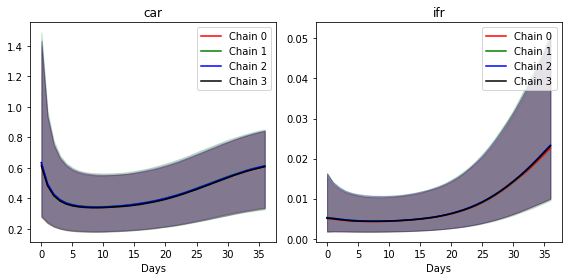

In [15]:
cols = min(len(time_params),4)
rows = math.ceil(len(time_params)/4)
fig, axes = plt.subplots(rows, cols, squeeze=False, figsize=(4*cols, 4*rows))
chains = samples['chain'].unique()
colors = 'rgbk'
for i, param in enumerate(time_params):
    options = {}
    ax = axes.flat[i]
    for chain in chains:
        cols = [col for col in samples if param in col]
        chain_samples = samples[samples['chain']==chain][cols]
        quantiles = chain_samples.quantile([0.05, 0.5, 0.95]).T.reset_index(drop=True)
        ax.plot(quantiles.index, quantiles[0.5], label=('Chain %d' % chain), color=colors[chain])
        ax.fill_between(quantiles.index, quantiles[0.05], quantiles[0.95], alpha=0.2, color=colors[chain])
    ax.legend()
    ax.set_title(param)
    ax.set_xlabel('Days')
plt.tight_layout()

### Visualize data and fits

t0 index assumed to be: day 1
t0 date: 03/05/20
tm index assumed to be: day 11
mitigation date: 03/15/20


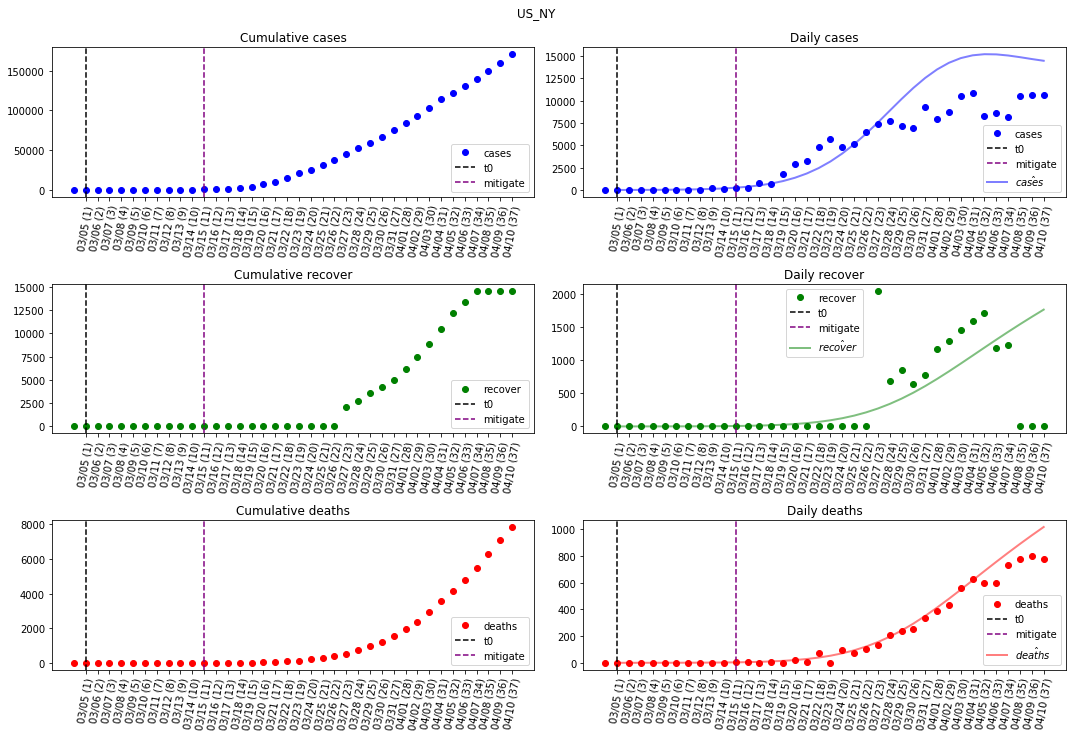

In [20]:
t0 = np.where(data["new_cases"].values>=10)[0][0] 
tm = t0 + 10
days, day_labels = zip(*data['dates2'][t0:].apply(lambda x:x[:-3]).iteritems())
day_labels = ['%s (%d)' % (day_labels[i], days[i]) for i in range(len(days))]

fig, ax = plt.subplots(3, 2, figsize=(15, 10))

estimates = {}
for chain in chains:
    chain_samples = samples[samples['chain']==chain]
    estimates['cases'] = [chain_samples['lambda[%d,0]' % (day-t0)].mean() for day in days]
    estimates['recover'] = [chain_samples['lambda[%d,1]' % (day-t0)].mean() for day in days]
    estimates['deaths'] = [chain_samples['lambda[%d,2]' % (day-t0)].mean() for day in days]

for i, kind in enumerate(['cases', 'recover', 'deaths']):
    colors = 'bgr'
    ax[i, 0].set_title('Cumulative %s' % kind)
    ax[i, 0].plot(data["cum_%s" % kind],'bo', color=colors[i], label=kind)
    ax[i, 0].axvline(t0, color='k', linestyle="dashed", label='t0')
    ax[i, 0].axvline(tm, color='purple', linestyle="dashed", label='mitigate')
    ax[i, 0].set_xticks(days)
    ax[i, 0].set_xticklabels(day_labels, rotation=80)
    ax[i, 0].legend()

    ax[i, 1].set_title('Daily %s' % kind)
    ax[i, 1].plot(data["new_%s" % kind], 'bo', color=colors[i], label=kind)
    ax[i, 1].axvline(t0, color='k', linestyle="dashed", label='t0')
    ax[i, 1].axvline(tm, color='purple', linestyle="dashed", label='mitigate')
    ax[i, 1].set_xticks(days)
    ax[i, 1].set_xticklabels(day_labels, rotation=80)
    if kind in estimates:
        ax[i, 1].plot(days, estimates[kind], label=r'$\hat{%s}$'% kind, linewidth=2, alpha=0.5, color=colors[i])
    ax[i, 1].legend()
    
plt.tight_layout()
fig.suptitle(roi, y=1.02)

print("t0 index assumed to be: day "+str(t0))
print("t0 date: "+data['dates2'][t0])
print("tm index assumed to be: day "+str(tm))
print("mitigation date: "+data['dates2'][tm])